# 0.0 IMPORTS

In [57]:
import pandas as pd
import inflection
import math
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 Helper Funcitions

In [55]:
#Função para configurar visualização dos boxplot em tamanho légivel
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

In [58]:
jupyter_settings()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [33]:
df_sales_raw = pd.read_csv( 'datasets/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'datasets/store.csv', low_memory=False )

# Merge dos datasets
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 PASSO 01 - DESCRICAO DOS DADOS

In [34]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [35]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Função lambda que transforma colunas em novos nomes snakecase
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ))

# Rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [36]:
print( 'Número de linhas: {}'.format( df1.shape[0]))
print( 'Número de Colunas: {}'.format( df1.shape[1]))

Número de linhas: 1017209
Número de Colunas: 18


## 1.3 Data Types

In [37]:
#Transforma coluna date em formato de data
df1['date'] = pd.to_datetime( df1['date'] )

# Método que retorna tipos da colunas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [38]:
#Retorna soma dos dados faltantes
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [39]:
df1['competition_distance'].max()

75860.0

In [40]:
#competition_distance: Premissa(Se não existe um competidor próximo é por que está muito distante do mais próximo para ser considerado competidor)
#Aplica uma função lambda que substitui NA por 200000.0 (Valor maior que o dobro da maior distancia do dataset)
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.00 if math.isnan( x ) else x)
              
#competition_open_since_month
#Aplica uma função lambda que substitui NA pela mês da data de venda.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
#Aplica uma função lambda que substitui NA ano da data de venda.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
     
#promo2_since_week
#Substitui os dados faltantes pela semana da data de venda.
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year
#Substitui os dados faltantes pelo ano da data de venda.
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
            
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

# Fillna para substituir NA por 0 direto na coluna
df1['promo_interval'].fillna(0, inplace=True)

#
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)




## 1.6 Change Types

In [41]:
#Modifica tipo das colunas
#competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
#promo 2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [48]:
#Separa as variaveis numericas e categoricas
num_atributes = df1.select_dtypes( include=['int64', 'float64', 'int32'])
cat_atributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]', 'int32'])

## 1.7.1 Numerical Attributes

In [43]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame( num_atributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis. skew() kurtosis()
d1 = pd.DataFrame( num_atributes.apply( np.std )).T
d2 = pd.DataFrame( num_atributes.apply( min )).T
d3 = pd.DataFrame( num_atributes.apply( max )).T
d4 = pd.DataFrame( num_atributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_atributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_atributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate
m = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['Attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,Attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


## 1.7.2 Categorical Atributes

In [49]:
#Quantidades de níveis de cada variavel categorica
cat_atributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

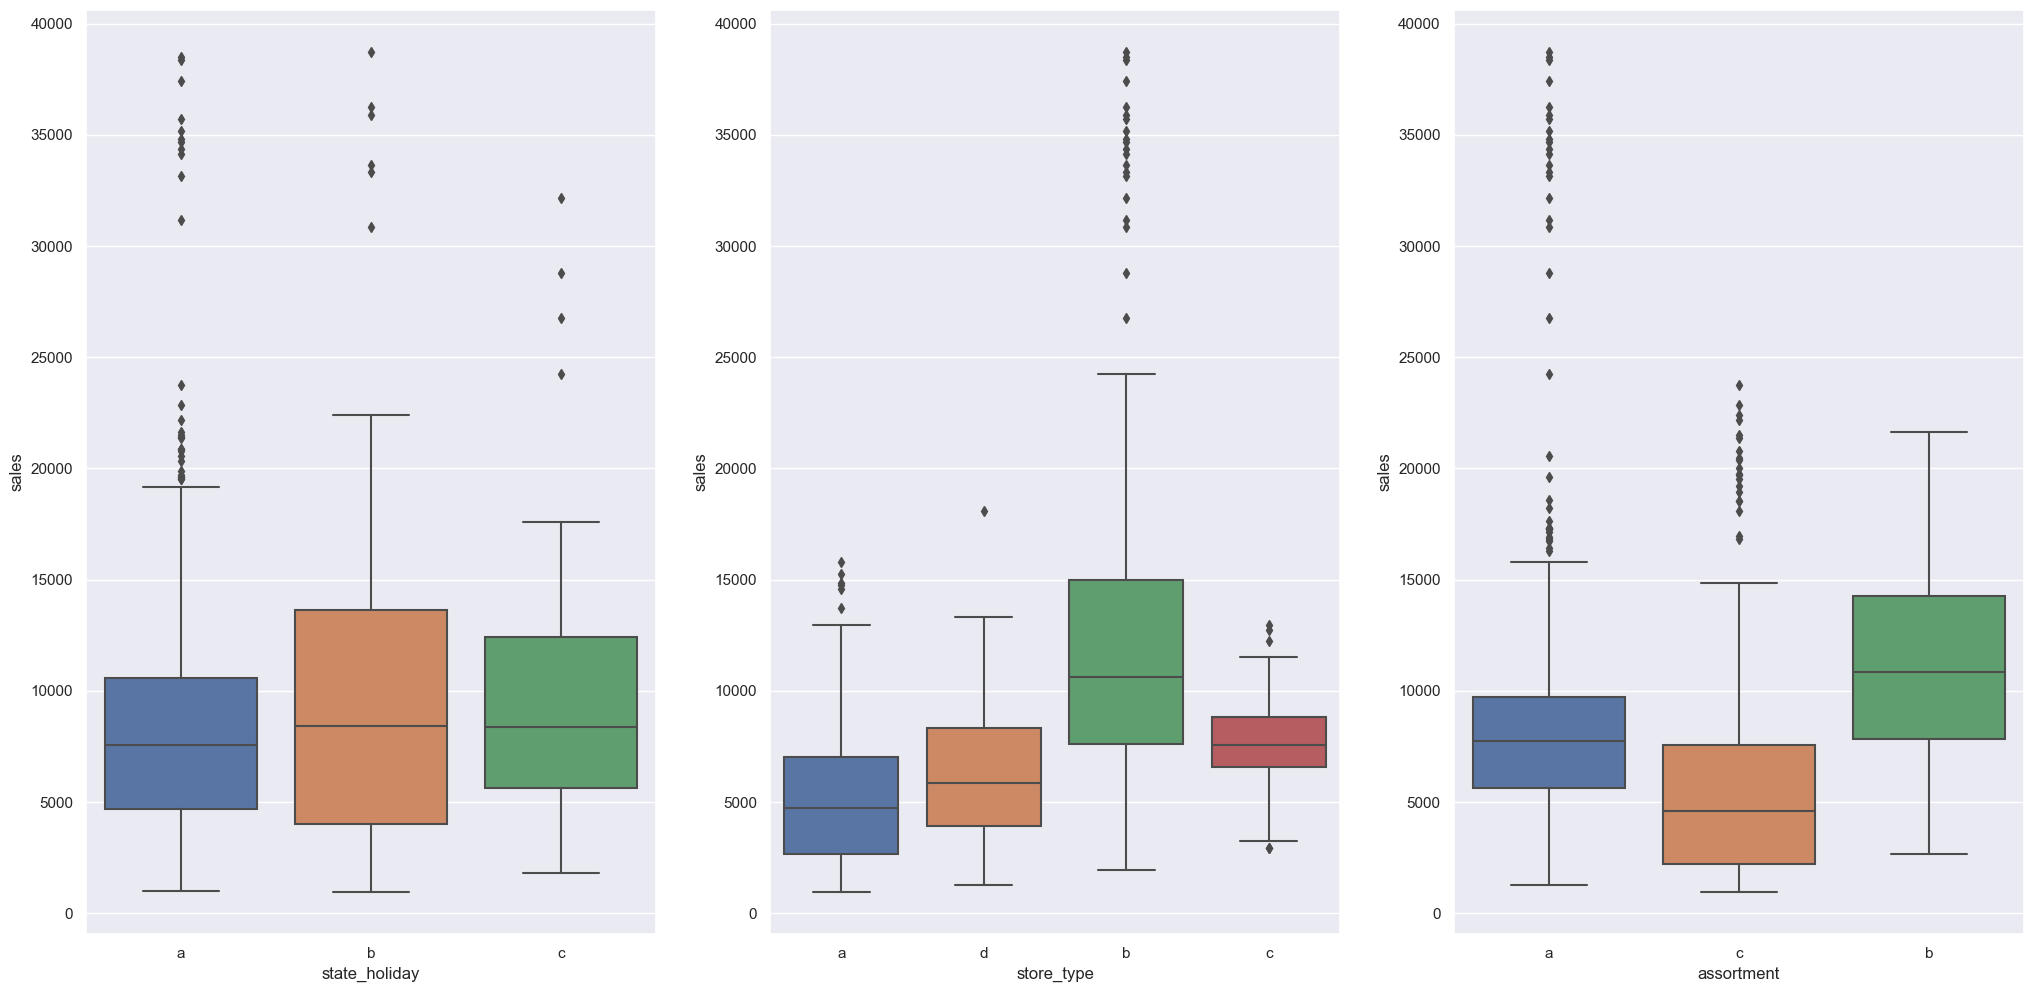

In [59]:
# Filtra que elimina dias que a loja está fechada e com vendas maiores que 0
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

#Plato as 3 boxplots para cada variavel juntas
plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux )